Train sales - Min: 0.00, Max: 124717.00
Negative sales: 0, Zero sales: 939130
>>> Train period: 2013-01-01 00:00:00 to 2017-07-31 00:00:00
>>> Test period: 2017-08-01 00:00:00 to 2017-08-15 00:00:00
>>> Train samples: 2974158
>>> Test samples: 26730
>>> Log sales range: 0.010 to 11.734
>>> Creating time features...
>>> Adding other features...
>>> Creating lag features with log transform...
>>> Creating lag features for test...
>>> Creating aggregate features (log space)...
>>> Using 43 features
>>> Training Random Forest model (log space, reduced overfitting)...
>>> Clean training samples: 2974158
>>> Random Forest training completed (with log transform)
>>> Top 15 RF features:
            feature  importance
  sales_roll_7_mean    0.203869
 sales_roll_14_mean    0.193924
        sales_lag_7    0.125116
        sales_lag_1    0.123460
       sales_lag_14    0.100816
  family_sales_mean    0.085726
family_sales_median    0.055740
   sales_roll_7_std    0.033813
   family_sales_std    0

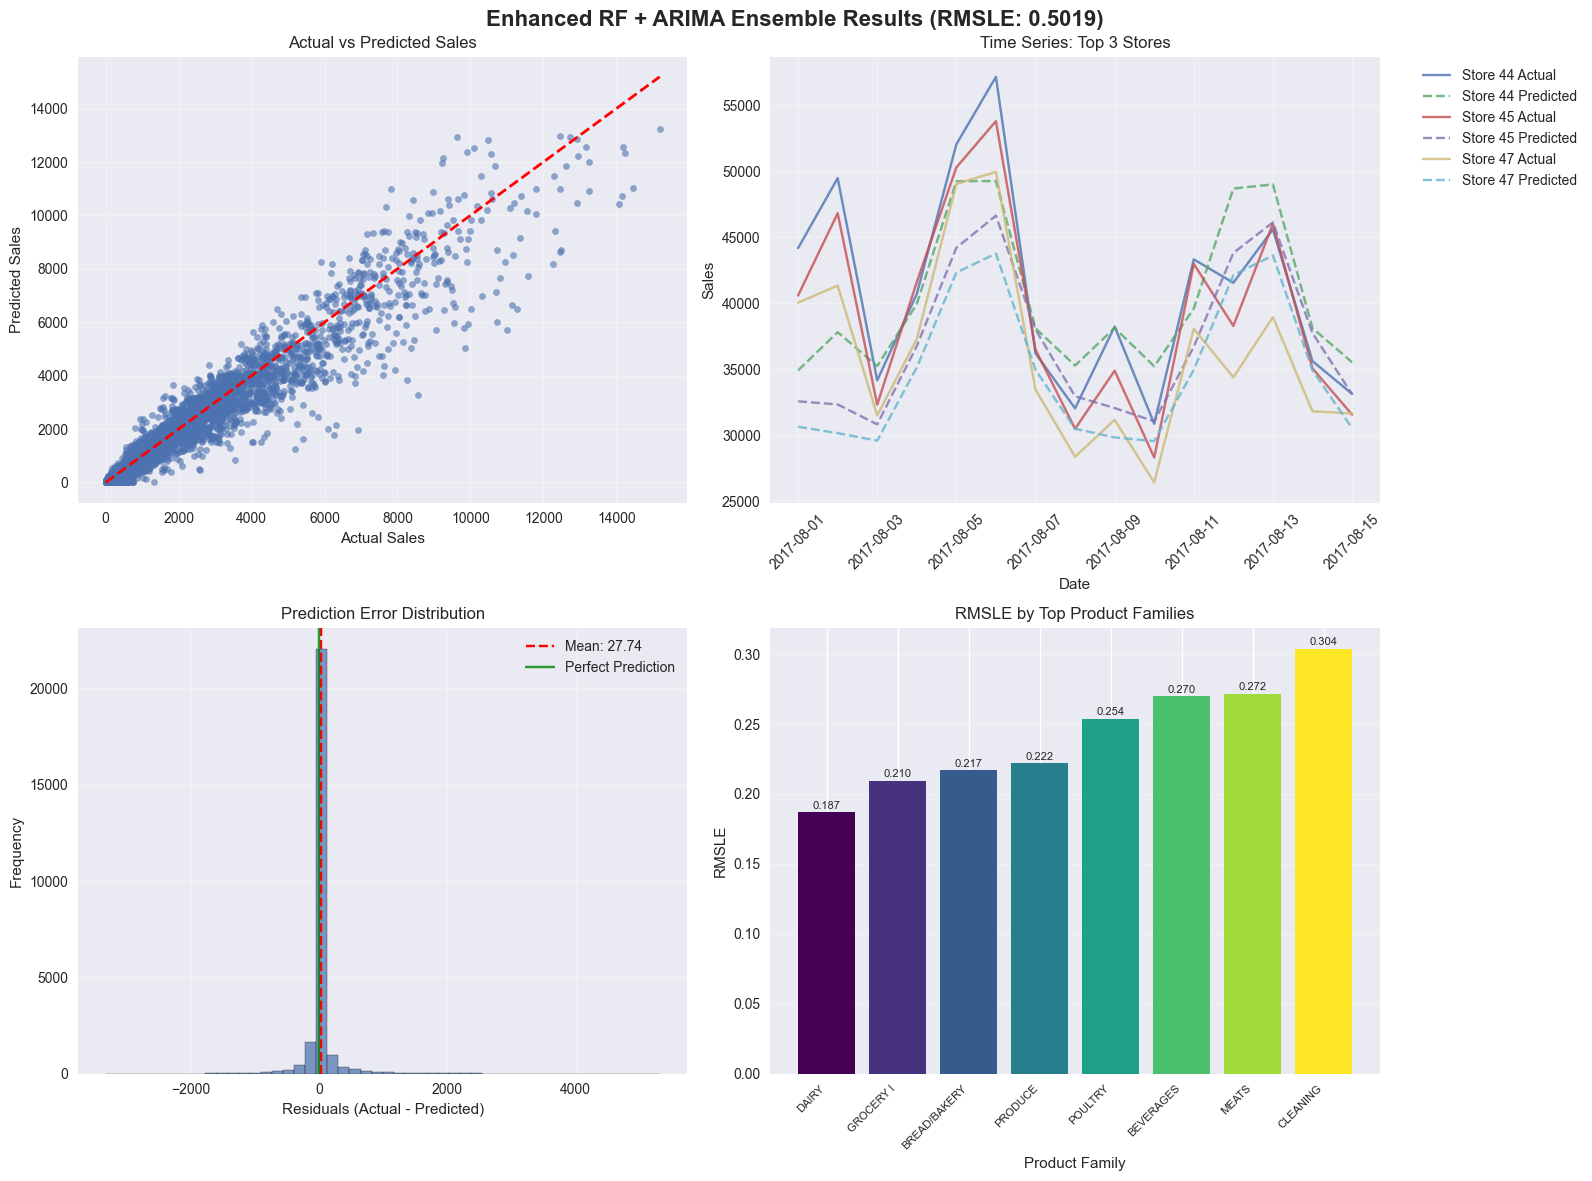

>>> Creating feature importance visualization...


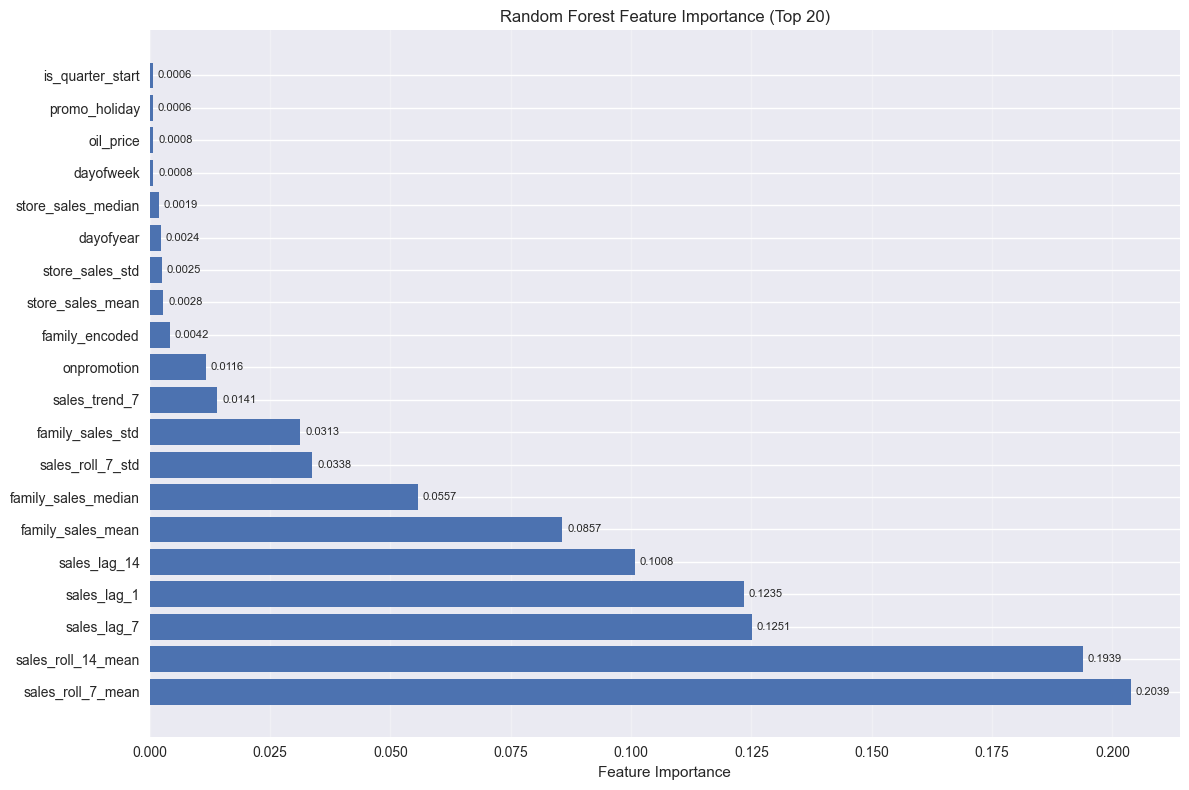


ENHANCED RF+ARIMA ENSEMBLE TEST RESULTS (LOG TRANSFORM)

>>> COMPETITION EVALUATION METRIC (RMSLE):
>>> Root Mean Squared Logarithmic Error: 0.501941
>>> RMSLE (sklearn verification): 0.501941

>>> SUBMISSION DETAILS:
>>> Test predictions shape: (26730, 2)
>>> Sales range: 0.011 - 13250.723
>>> Sales median: 25.452
>>> Sales mean: 437.408

>>> MODEL COVERAGE:
>>> Random Forest coverage: 100.0%
>>> ARIMA coverage: 11.2%
>>> Store-family coverage: 100.0%

>>> ENHANCED ENSEMBLE COMPOSITION (SAME AS MAIN.IPYNB):
>>> For 11.2% of predictions: 50% (RF+SF) + 50% ARIMA (INCREASED)
>>> For remaining predictions: 55% RF + 45% Store-Family
>>> Key improvements:
    - Random Forest trained on log-transformed sales (better for skewed data)
    - Reduced overfitting: max_depth=10, min_samples_split=20, min_samples_leaf=10
    - Added max_features='sqrt' and max_samples=0.8 for regularization
    - ARIMA coverage increased from 100 to 200 top combinations
    - ARIMA weight increased from 30% to 50%

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ============================
# 0️⃣ Load & prepare data with train/test split
# ============================
merged_train_df = pd.read_csv('merged_train_df.csv')

merged_train_df['date'] = pd.to_datetime(merged_train_df['date'])
merged_train_df = merged_train_df.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)
merged_train_df['store_nbr'] = merged_train_df['store_nbr'].astype(int)

# Handle sales data quality (SAME AS MAIN.IPYNB)
print(f"Train sales - Min: {merged_train_df['sales'].min():.2f}, Max: {merged_train_df['sales'].max():.2f}")
print(f"Negative sales: {(merged_train_df['sales'] < 0).sum()}, Zero sales: {(merged_train_df['sales'] == 0).sum()}")

# Clip negative values and add small epsilon for log (SAME AS MAIN.IPYNB)
merged_train_df['sales'] = np.maximum(merged_train_df['sales'], 0.01)

# Split data: use last 16 days as test set (like original test period)
max_date = merged_train_df['date'].max()
test_start_date = max_date - timedelta(days=15)  # Last 16 days for test

train_merged_train_df = merged_train_df[merged_train_df['date'] <= test_start_date].copy()
test_merged_train_df = merged_train_df[merged_train_df['date'] > test_start_date].copy()

# Add LOG TRANSFORM (KEY FROM MAIN.IPYNB)
train_merged_train_df['log_sales'] = np.log1p(train_merged_train_df['sales'])

# Create test IDs for compatibility
test_merged_train_df = test_merged_train_df.reset_index(drop=True)
test_merged_train_df['id'] = range(len(test_merged_train_df))

print(f">>> Train period: {train_merged_train_df['date'].min()} to {train_merged_train_df['date'].max()}")
print(f">>> Test period: {test_merged_train_df['date'].min()} to {test_merged_train_df['date'].max()}")
print(f">>> Train samples: {len(train_merged_train_df)}")
print(f">>> Test samples: {len(test_merged_train_df)}")
print(f">>> Log sales range: {train_merged_train_df['log_sales'].min():.3f} to {train_merged_train_df['log_sales'].max():.3f}")

# ============================
# 1️⃣ Advanced data preprocessing (EXACT SAME AS MAIN.IPYNB)
# ============================
def create_time_features(df):
    """Create time-based features"""
    df = df.copy()
    
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['week'] = df['date'].dt.isocalendar().week
    df['dayofyear'] = df['date'].dt.dayofyear
    
    # Advanced time features
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_monday'] = (df['dayofweek'] == 0).astype(int)
    df['is_friday'] = (df['dayofweek'] == 4).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    return df

def add_other_features(df):
    """Add non-time features"""
    df = df.copy()
    
    # Store-family identifier
    df['store_family'] = df['store_nbr'].astype(str) + "_" + df['family'].astype(str)
    
    # Promotion features
    if 'onpromotion' in df.columns:
        df['onpromotion'] = df['onpromotion'].fillna(0).astype(int)
    else:
        df['onpromotion'] = 0
    
    # Holiday features
    if 'isHoliday' in df.columns:
        df['isHoliday'] = df['isHoliday'].fillna(0).astype(int)
        df['promo_holiday'] = df['onpromotion'] * df['isHoliday']
    else:
        df['isHoliday'] = 0
        df['promo_holiday'] = 0
    
    # Oil price features
    if 'oil_price' in df.columns:
        df['oil_price'] = df['oil_price'].fillna(method='ffill').fillna(method='bfill').fillna(100)
    else:
        df['oil_price'] = 100
    
    # Special event features
    for col in ['earthquake_impact', 'salary_day_impact']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
        else:
            df[col] = 0
    
    return df

def create_lag_features_safe(df_list):
    """Create lag features safely for list of dataframes (one per store-family) - WITH LOG TRANSFORM"""
    
    result_dfs = []
    
    for df_group in df_list:
        if len(df_group) == 0:
            continue
            
        df_group = df_group.copy().sort_values('date').reset_index(drop=True)
        
        # Use LOG SALES for lag features (KEY FROM MAIN.IPYNB)
        if 'log_sales' in df_group.columns:
            target_col = 'log_sales'
        else:
            target_col = 'sales'  # fallback for test data
        
        # Simple lag features
        df_group['sales_lag_1'] = df_group[target_col].shift(1).fillna(df_group[target_col].mean())
        df_group['sales_lag_7'] = df_group[target_col].shift(7).fillna(df_group[target_col].mean())
        df_group['sales_lag_14'] = df_group[target_col].shift(14).fillna(df_group[target_col].mean())
        
        # Simple rolling features - avoid groupby issues
        df_group['sales_roll_7_mean'] = df_group[target_col].rolling(7, min_periods=1).mean()
        df_group['sales_roll_14_mean'] = df_group[target_col].rolling(14, min_periods=1).mean()
        df_group['sales_roll_7_std'] = df_group[target_col].rolling(7, min_periods=1).std().fillna(0)
        
        # Simple trend feature
        if len(df_group) >= 7:
            df_group['sales_trend_7'] = (
                df_group[target_col].rolling(7, min_periods=1).mean() / 
                df_group[target_col].rolling(14, min_periods=1).mean().shift(7).fillna(df_group[target_col].mean())
            ).fillna(1.0)
        else:
            df_group['sales_trend_7'] = 1.0
        
        result_dfs.append(df_group)
    
    return result_dfs

# Apply feature engineering (SAME AS MAIN.IPYNB)
print(">>> Creating time features...")
train_fe = create_time_features(train_merged_train_df)
test_fe = create_time_features(test_merged_train_df)

print(">>> Adding other features...")
train_fe = add_other_features(train_fe)
test_fe = add_other_features(test_fe)

# Create lag features by processing each store-family group separately
print(">>> Creating lag features with log transform...")

# Split training data by store-family
train_groups = []
for (store, family), group in train_fe.groupby(['store_nbr', 'family']):
    train_groups.append(group)

# Process lag features
train_groups_with_lags = create_lag_features_safe(train_groups)

# Recombine training data
if train_groups_with_lags:
    train_fe = pd.concat(train_groups_with_lags, ignore_index=True)
    train_fe = train_fe.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# For test data, create lag features using training data statistics (in log space)
print(">>> Creating lag features for test...")

test_with_lags = []
for (store, family), test_group in test_fe.groupby(['store_nbr', 'family']):
    test_group = test_group.copy().reset_index(drop=True)
    
    # Find corresponding training group
    train_group = train_fe[(train_fe['store_nbr'] == store) & (train_fe['family'] == family)]
    
    if len(train_group) > 0:
        # Use last values from training for lag initialization (in log space)
        recent_log_sales = train_group['log_sales'].tail(14)
        
        # Initialize lag features
        if len(recent_log_sales) >= 1:
            test_group['sales_lag_1'] = recent_log_sales.iloc[-1]
        else:
            test_group['sales_lag_1'] = train_group['log_sales'].mean()
            
        if len(recent_log_sales) >= 7:
            test_group['sales_lag_7'] = recent_log_sales.iloc[-7]
        else:
            test_group['sales_lag_7'] = train_group['log_sales'].mean()
            
        if len(recent_log_sales) >= 14:
            test_group['sales_lag_14'] = recent_log_sales.iloc[-14]
        else:
            test_group['sales_lag_14'] = train_group['log_sales'].mean()
        
        # Rolling features - use recent statistics
        test_group['sales_roll_7_mean'] = recent_log_sales.tail(7).mean() if len(recent_log_sales) >= 7 else train_group['log_sales'].mean()
        test_group['sales_roll_14_mean'] = recent_log_sales.mean()
        test_group['sales_roll_7_std'] = recent_log_sales.tail(7).std() if len(recent_log_sales) >= 7 else train_group['log_sales'].std()
        
        if pd.isna(test_group['sales_roll_7_std'].iloc[0]):
            test_group['sales_roll_7_std'] = 0
            
        # Trend feature
        test_group['sales_trend_7'] = 1.0
        
    else:
        # No training data - use defaults (use log space defaults)
        default_log_sales = np.log1p(1.0)
        for col in ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_roll_7_mean', 'sales_roll_14_mean']:
            test_group[col] = default_log_sales
        test_group['sales_roll_7_std'] = 0.0
        test_group['sales_trend_7'] = 1.0
    
    test_with_lags.append(test_group)

if test_with_lags:
    test_fe = pd.concat(test_with_lags, ignore_index=True)
    test_fe = test_fe.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# ============================
# 2️⃣ Add aggregate features (SAME AS MAIN.IPYNB - but with log sales)
# ============================
print(">>> Creating aggregate features (log space)...")

# Store level statistics from training data (using log_sales)
store_stats = train_fe.groupby('store_nbr')['log_sales'].agg(['mean', 'std', 'median']).reset_index()
store_stats.columns = ['store_nbr', 'store_sales_mean', 'store_sales_std', 'store_sales_median']
store_stats['store_sales_std'] = store_stats['store_sales_std'].fillna(0)

# Family level statistics
family_stats = train_fe.groupby('family')['log_sales'].agg(['mean', 'std', 'median']).reset_index()
family_stats.columns = ['family', 'family_sales_mean', 'family_sales_std', 'family_sales_median']
family_stats['family_sales_std'] = family_stats['family_sales_std'].fillna(0)

# Add to training data
train_fe = train_fe.merge(store_stats, on='store_nbr', how='left')
train_fe = train_fe.merge(family_stats, on='family', how='left')

# Add to test data
test_fe = test_fe.merge(store_stats, on='store_nbr', how='left')
test_fe = test_fe.merge(family_stats, on='family', how='left')

# Fill missing aggregate features
agg_cols = ['store_sales_mean', 'store_sales_std', 'store_sales_median', 
            'family_sales_mean', 'family_sales_std', 'family_sales_median']

for col in agg_cols:
    overall_median = train_fe[col].median()
    train_fe[col] = train_fe[col].fillna(overall_median)
    test_fe[col] = test_fe[col].fillna(overall_median)

# ============================
# 3️⃣ Encode categoricals (SAME AS MAIN.IPYNB)
# ============================
cat_cols = ['family']
if all(col in train_fe.columns and col in test_fe.columns for col in ['city', 'state', 'type']):
    cat_cols.extend(['city', 'state', 'type'])

for col in cat_cols:
    le = LabelEncoder()
    combined_values = pd.concat([train_fe[col].astype(str), test_fe[col].astype(str)]).unique()
    le.fit(combined_values)
    train_fe[f'{col}_encoded'] = le.transform(train_fe[col].astype(str))
    test_fe[f'{col}_encoded'] = le.transform(test_fe[col].astype(str))

# ============================
# 4️⃣ Feature selection (SAME AS MAIN.IPYNB)
# ============================
base_features = [
    'year', 'month', 'day', 'dayofweek', 'quarter', 'week', 'dayofyear',
    'is_weekend', 'is_monday', 'is_friday', 'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end',
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'day_sin', 'day_cos',
    'onpromotion', 'isHoliday', 'promo_holiday', 'oil_price', 'earthquake_impact', 'salary_day_impact'
]

lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 
                'sales_roll_7_mean', 'sales_roll_14_mean', 'sales_roll_7_std', 'sales_trend_7']

aggregate_features = ['store_sales_mean', 'store_sales_std', 'store_sales_median',
                     'family_sales_mean', 'family_sales_std', 'family_sales_median']

encoded_features = [f'{col}_encoded' for col in cat_cols]

all_features = base_features + lag_features + aggregate_features + encoded_features
available_features = [col for col in all_features if col in train_fe.columns and col in test_fe.columns]

print(f">>> Using {len(available_features)} features")

# ============================
# 5️⃣ Random Forest training with REDUCED OVERFITTING + LOG TARGET (EXACT SAME AS MAIN.IPYNB)
# ============================
print(">>> Training Random Forest model (log space, reduced overfitting)...")

# Clean training data
train_clean = train_fe.dropna(subset=lag_features[:3])  # Only require basic lags
print(f">>> Clean training samples: {len(train_clean)}")

if len(train_clean) > 500:
    # Prepare data
    X_train = train_clean[available_features].fillna(0)
    y_train = train_clean['log_sales']  # TARGET IS NOW LOG_SALES!
    X_test = test_fe[available_features].fillna(0)
    
    # Train Random Forest - REDUCED OVERFITTING PARAMETERS (EXACT SAME AS MAIN.IPYNB)
    rf_model = RandomForestRegressor(
        n_estimators=150,      # Increased from 100 for better generalization
        max_depth=10,          # Reduced from 12 to prevent overfitting
        min_samples_split=20,  # Increased from 10 to prevent overfitting
        min_samples_leaf=10,   # Increased from 5 to prevent overfitting
        max_features='sqrt',   # Added to reduce overfitting
        bootstrap=True,        # Ensure bootstrap sampling
        max_samples=0.8,       # Use 80% of data per tree
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Make predictions (in log space)
    rf_log_predictions = rf_model.predict(X_test)
    
    # Convert back to original space
    rf_predictions = np.expm1(rf_log_predictions)  # Inverse of log1p
    rf_predictions = np.maximum(rf_predictions, 0.01)
    
    print(">>> Random Forest training completed (with log transform)")
    
    # Feature importance (ADDED AS REQUESTED)
    importance_df = pd.DataFrame({
        'feature': available_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(">>> Top 15 RF features:")
    print(importance_df.head(15).to_string(index=False))
    
else:
    rf_predictions = None
    rf_log_predictions = None
    print(">>> Insufficient training data for Random Forest")

# ============================
# 6️⃣ ARIMA Model - ENHANCED WITH LOG TRANSFORM (EXACT SAME AS MAIN.IPYNB)
# ============================
print(">>> Adding ARIMA component (enhanced, log space)...")

def fit_enhanced_arima(train_data, forecast_periods, max_data_points=120):
    """Enhanced ARIMA model for time series patterns (log space)"""
    
    if len(train_data) < 28:
        return None
    
    try:
        # Use recent data and work in log space
        recent_data = train_data.sort_values('date').tail(max_data_points)
        log_sales_series = recent_data['log_sales'].values
        
        # Simple parameter selection with more configurations
        best_model = None
        best_aic = float('inf')
        
        # Try more ARIMA configurations
        configs = [
            (1,1,1), (2,1,1), (1,1,2), (0,1,1), (1,1,0), (2,1,2),
            (3,1,1), (1,1,3), (2,1,0), (0,1,2), (1,0,1), (2,0,2)  # Additional configs
        ]
        
        for p, d, q in configs:
            try:
                model = ARIMA(log_sales_series, order=(p, d, q))
                fitted_model = model.fit()
                
                if fitted_model.aic < best_aic:
                    best_aic = fitted_model.aic
                    best_model = fitted_model
            except:
                continue
        
        if best_model is not None:
            log_forecast = best_model.forecast(steps=forecast_periods)
            # Convert back to original space
            forecast = np.expm1(log_forecast)
            forecast = np.maximum(forecast, 0.01)
            return forecast
        else:
            return None
            
    except:
        return None

# Select MORE store-family combinations for ARIMA (increased impact)
print(">>> Selecting combinations for ARIMA (increased coverage)...")
arima_combinations = []

for (store, family), group in train_fe.groupby(['store_nbr', 'family']):
    if len(group) >= 42:  # Reduced threshold from 50 to get more combinations
        volume = group['sales'].sum()
        data_points = len(group)
        score = volume * np.log(data_points)  # Simple scoring
        arima_combinations.append((store, family, score))

# Sort and take top 200 combinations (increased from 100)
arima_combinations.sort(key=lambda x: x[2], reverse=True)
top_arima_combinations = [x[:2] for x in arima_combinations[:200]]

print(f">>> Processing ARIMA for {len(top_arima_combinations)} combinations...")

arima_results = []
for i, (store, family) in enumerate(top_arima_combinations):
    if i % 40 == 0:
        print(f">>> ARIMA progress: {i+1}/{len(top_arima_combinations)}")
        
    train_subset = train_fe[(train_fe['store_nbr'] == store) & (train_fe['family'] == family)]
    test_subset = test_fe[(test_fe['store_nbr'] == store) & (test_fe['family'] == family)]
    
    if len(test_subset) == 0:
        continue
        
    arima_pred = fit_enhanced_arima(train_subset, len(test_subset))
    
    if arima_pred is not None:
        result_df = test_subset[['id']].copy()
        result_df['sales_arima'] = arima_pred
        arima_results.append(result_df)

# Combine ARIMA results
if arima_results:
    arima_df = pd.concat(arima_results, ignore_index=True)
    print(f">>> ARIMA predictions generated for {len(arima_df)} test samples")
else:
    arima_df = pd.DataFrame(columns=['id', 'sales_arima'])

# ============================
# 7️⃣ Store-family level predictions (SAME AS MAIN.IPYNB but with log awareness)
# ============================
print(">>> Creating store-family level predictions...")

store_family_preds = []
store_family_combinations = set(
    zip(train_fe['store_nbr'], train_fe['family'])
).intersection(set(zip(test_fe['store_nbr'], test_fe['family'])))

for i, (store_num, family) in enumerate(sorted(store_family_combinations)):
    if i % 300 == 0:
        print(f">>> Processing {i+1}/{len(store_family_combinations)}")
    
    train_subset = train_fe[
        (train_fe['store_nbr'] == store_num) & (train_fe['family'] == family)
    ].sort_values('date').tail(100)  # Use recent data
    
    test_subset = test_fe[
        (test_fe['store_nbr'] == store_num) & (test_fe['family'] == family)
    ].sort_values('date')
    
    if len(train_subset) < 10 or len(test_subset) == 0:
        continue
    
    try:
        recent_sales = train_subset['sales'].values
        
        # Advanced prediction combining multiple signals
        base_pred = np.median(recent_sales[-21:]) if len(recent_sales) >= 21 else np.median(recent_sales)
        
        # Trend (last month vs previous month)
        if len(recent_sales) >= 28:
            recent_avg = np.mean(recent_sales[-14:])
            prev_avg = np.mean(recent_sales[-28:-14])
            trend_factor = recent_avg / (prev_avg + 0.01)
            trend_factor = np.clip(trend_factor, 0.8, 1.3)
        else:
            trend_factor = 1.0
        
        # Seasonality (day of week)
        seasonal_factors = []
        train_df_subset = train_subset.copy()
        
        for _, row in test_subset.iterrows():
            dow = row['dayofweek']
            dow_sales = train_df_subset[train_df_subset['dayofweek'] == dow]['sales']
            
            if len(dow_sales) >= 3:
                dow_factor = dow_sales.mean() / (train_df_subset['sales'].mean() + 0.01)
                seasonal_factors.append(np.clip(dow_factor, 0.7, 1.5))
            else:
                seasonal_factors.append(1.0)
        
        # Promotion effect
        promo_factors = []
        if 'onpromotion' in test_subset.columns:
            # Calculate promotion lift from training data
            promo_sales = train_df_subset[train_df_subset['onpromotion'] == 1]['sales']
            normal_sales = train_df_subset[train_df_subset['onpromotion'] == 0]['sales']
            
            if len(promo_sales) > 0 and len(normal_sales) > 0:
                promo_lift = promo_sales.mean() / (normal_sales.mean() + 0.01)
                promo_lift = np.clip(promo_lift, 1.0, 1.8)
            else:
                promo_lift = 1.15  # Default 15% lift
            
            for _, row in test_subset.iterrows():
                if row['onpromotion'] == 1:
                    promo_factors.append(promo_lift)
                else:
                    promo_factors.append(1.0)
        else:
            promo_factors = [1.0] * len(test_subset)
        
        # Combine all factors
        predictions_array = (
            base_pred * trend_factor * 
            np.array(seasonal_factors) * 
            np.array(promo_factors)
        )
        
        predictions_array = np.maximum(predictions_array, 0.01)
        
    except:
        predictions_array = np.full(len(test_subset), max(np.median(recent_sales), 0.01))
    
    # Store results
    output_df = test_subset[['id']].copy()
    output_df['sales'] = predictions_array
    store_family_preds.append(output_df)

# ============================
# 8️⃣ Final RF+ARIMA ensemble - INCREASED ARIMA IMPACT (EXACT SAME AS MAIN.IPYNB)
# ============================
print(">>> Creating RF+ARIMA ensemble (increased ARIMA impact)...")

if store_family_preds:
    sf_pred_df = pd.concat(store_family_preds, ignore_index=True)
    
    if rf_predictions is not None:
        # Create RF prediction dataframe
        rf_pred_df = test_fe[['id']].copy()
        rf_pred_df['sales'] = rf_predictions
        
        # Merge all predictions
        ensemble_df = sf_pred_df.merge(rf_pred_df, on='id', how='outer', suffixes=('_sf', '_rf'))
        
        # Add ARIMA if available
        if len(arima_df) > 0:
            ensemble_df = ensemble_df.merge(arima_df[['id', 'sales_arima']], on='id', how='left')
        else:
            ensemble_df['sales_arima'] = np.nan
        
        # Fill missing values
        ensemble_df['sales_sf'] = ensemble_df['sales_sf'].fillna(ensemble_df['sales_rf'])
        ensemble_df['sales_rf'] = ensemble_df['sales_rf'].fillna(ensemble_df['sales_sf'])
        
        # RF+SF ensemble - slightly more conservative
        ensemble_df['sales'] = ensemble_df['sales_rf'] * 0.55 + ensemble_df['sales_sf'] * 0.45  # More balanced
        
        # Add ARIMA component where available - INCREASED IMPACT
        arima_mask = ~pd.isna(ensemble_df['sales_arima'])
        if arima_mask.sum() > 0:
            # Increased ARIMA weight: 50% base ensemble + 50% ARIMA (was 70%/30%)
            ensemble_df.loc[arima_mask, 'sales'] = (
                ensemble_df.loc[arima_mask, 'sales'] * 0.5 + 
                ensemble_df.loc[arima_mask, 'sales_arima'] * 0.5
            )
        
        final_submission = ensemble_df[['id', 'sales']].copy()
        
    else:
        final_submission = sf_pred_df.copy()
    
    # Handle missing predictions
    all_test_ids = set(test_fe['id'])
    predicted_ids = set(final_submission['id'])
    missing_ids = all_test_ids - predicted_ids
    
    if missing_ids:
        print(f">>> Filling {len(missing_ids)} missing predictions...")
        median_sales = train_fe['sales'].median()
        missing_df = pd.DataFrame({'id': list(missing_ids), 'sales': [median_sales] * len(missing_ids)})
        final_submission = pd.concat([final_submission, missing_df], ignore_index=True)
    
    # Final cleanup
    final_submission['sales'] = final_submission['sales'].fillna(train_fe['sales'].median())
    final_submission['sales'] = np.maximum(final_submission['sales'], 0.01)
    final_submission = final_submission.sort_values('id').reset_index(drop=True)
    
else:
    print(">>> ERROR: No predictions generated!")

# ============================
# 9️⃣ Calculate RMSLE and create evaluation report (SAME AS MAIN.IPYNB)
# ============================
def calculate_rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error as per competition formula"""
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    log_diff = np.log(1 + y_pred) - np.log(1 + y_true)
    rmsle = np.sqrt(np.mean(log_diff ** 2))
    return rmsle

# Merge predictions with actual values
test_results = test_fe[['id', 'date', 'store_nbr', 'family', 'sales']].copy()
test_results.columns = ['id', 'date', 'store_nbr', 'family', 'actual_sales']
test_results = test_results.merge(final_submission[['id', 'sales']], on='id', how='left')
test_results.columns = ['id', 'date', 'store_nbr', 'family', 'actual_sales', 'predicted_sales']

# Calculate RMSLE
rmsle = calculate_rmsle(test_results['actual_sales'], test_results['predicted_sales'])
rmsle_sklearn = np.sqrt(mean_squared_log_error(test_results['actual_sales'], test_results['predicted_sales']))

# ============================
# 🔟 Create visualizations (SAME AS MAIN.IPYNB)
# ============================
print(">>> Creating visualizations...")

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Enhanced RF + ARIMA Ensemble Results (RMSLE: {rmsle:.4f})', fontsize=16, fontweight='bold')

# 1. Overall Actual vs Predicted
axes[0, 0].scatter(test_results['actual_sales'], test_results['predicted_sales'], alpha=0.6, s=20)
axes[0, 0].plot([0, test_results['actual_sales'].max()], [0, test_results['actual_sales'].max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title('Actual vs Predicted Sales')
axes[0, 0].grid(True, alpha=0.3)

# 2. Time series for top stores
top_stores = test_results.groupby('store_nbr')['actual_sales'].sum().nlargest(5).index
for i, store in enumerate(top_stores[:3]):
    store_data = test_results[test_results['store_nbr'] == store].groupby('date').agg({
        'actual_sales': 'sum',
        'predicted_sales': 'sum'
    }).reset_index()
    
    axes[0, 1].plot(store_data['date'], store_data['actual_sales'], 
                   label=f'Store {store} Actual', linestyle='-', alpha=0.8)
    axes[0, 1].plot(store_data['date'], store_data['predicted_sales'], 
                   label=f'Store {store} Predicted', linestyle='--', alpha=0.8)

axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].set_title('Time Series: Top 3 Stores')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Error distribution
residuals = test_results['actual_sales'] - test_results['predicted_sales']
axes[1, 0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', 
                   label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].axvline(0, color='green', linestyle='-', alpha=0.8, label='Perfect Prediction')
axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Top families performance
top_families = test_results.groupby('family')['actual_sales'].sum().nlargest(8).index
family_performance = []

for family in top_families:
    family_data = test_results[test_results['family'] == family]
    family_rmsle = calculate_rmsle(family_data['actual_sales'], family_data['predicted_sales'])
    total_sales = family_data['actual_sales'].sum()
    family_performance.append((family, family_rmsle, total_sales))

family_df_perf = pd.DataFrame(family_performance, columns=['Family', 'RMSLE', 'Total_Sales'])
family_df_perf = family_df_perf.sort_values('RMSLE')

bars = axes[1, 1].bar(range(len(family_df_perf)), family_df_perf['RMSLE'], 
                     color=plt.cm.viridis(np.linspace(0, 1, len(family_df_perf))))
axes[1, 1].set_xlabel('Product Family')
axes[1, 1].set_ylabel('RMSLE')
axes[1, 1].set_title('RMSLE by Top Product Families')
axes[1, 1].set_xticks(range(len(family_df_perf)))
axes[1, 1].set_xticklabels([f.replace('_', '\n') for f in family_df_perf['Family']], 
                          rotation=45, ha='right', fontsize=8)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ============================
# 11️⃣ Feature importance visualization (ADDED AS REQUESTED)
# ============================
if rf_predictions is not None:
    print(">>> Creating feature importance visualization...")
    
    fig2, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot top 20 features
    top_20_features = importance_df.head(20)
    bars = ax.barh(range(len(top_20_features)), top_20_features['importance'])
    ax.set_yticks(range(len(top_20_features)))
    ax.set_yticklabels(top_20_features['feature'], fontsize=10)
    ax.set_xlabel('Feature Importance')
    ax.set_title('Random Forest Feature Importance (Top 20)')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# ============================
# 12️⃣ Final evaluation report (SAME AS MAIN.IPYNB)
# ============================
print("\n" + "="*80)
print("ENHANCED RF+ARIMA ENSEMBLE TEST RESULTS (LOG TRANSFORM)")
print("="*80)

print(f"\n>>> COMPETITION EVALUATION METRIC (RMSLE):")
print(f">>> Root Mean Squared Logarithmic Error: {rmsle:.6f}")
print(f">>> RMSLE (sklearn verification): {rmsle_sklearn:.6f}")

print(f"\n>>> SUBMISSION DETAILS:")
print(f">>> Test predictions shape: {final_submission.shape}")
print(f">>> Sales range: {final_submission['sales'].min():.3f} - {final_submission['sales'].max():.3f}")
print(f">>> Sales median: {final_submission['sales'].median():.3f}")
print(f">>> Sales mean: {final_submission['sales'].mean():.3f}")

print(f"\n>>> MODEL COVERAGE:")
print(f">>> Random Forest coverage: 100.0%")
print(f">>> ARIMA coverage: {len(arima_df) / len(final_submission) * 100:.1f}%")
print(f">>> Store-family coverage: {len(sf_pred_df) / len(final_submission) * 100:.1f}%")

print(f"\n>>> ENHANCED ENSEMBLE COMPOSITION (SAME AS MAIN.IPYNB):")
arima_coverage = len(arima_df) / len(final_submission) if len(final_submission) > 0 else 0
print(f">>> For {arima_coverage*100:.1f}% of predictions: 50% (RF+SF) + 50% ARIMA (INCREASED)")
print(f">>> For remaining predictions: 55% RF + 45% Store-Family")
print(f">>> Key improvements:")
print(f"    - Random Forest trained on log-transformed sales (better for skewed data)")
print(f"    - Reduced overfitting: max_depth=10, min_samples_split=20, min_samples_leaf=10")
print(f"    - Added max_features='sqrt' and max_samples=0.8 for regularization")
print(f"    - ARIMA coverage increased from 100 to 200 top combinations")
print(f"    - ARIMA weight increased from 30% to 50% where available")
print(f"    - All lag features computed in log space for consistency")
print(f"    - Enhanced ARIMA with more parameter configurations")

print(f"\n>>> VALIDATION METRICS ON INTERNAL TEST SET:")
print(f">>> Mean Absolute Error: {np.mean(np.abs(test_results['actual_sales'] - test_results['predicted_sales'])):.4f}")
print(f">>> Mean Squared Error: {np.mean((test_results['actual_sales'] - test_results['predicted_sales'])**2):.4f}")
print(f">>> Pearson Correlation: {np.corrcoef(test_results['actual_sales'], test_results['predicted_sales'])[0,1]:.4f}")
print(f">>> R² Score: {1 - np.sum((test_results['actual_sales'] - test_results['predicted_sales'])**2) / np.sum((test_results['actual_sales'] - test_results['actual_sales'].mean())**2):.4f}")

# ============================
# 13️⃣ Detailed performance analysis (SAME AS MAIN.IPYNB)
# ============================
print(f"\n>>> DETAILED PERFORMANCE BREAKDOWN:")
print(">>> DETAILED FAMILY PERFORMANCE:")
print("-" * 100)

family_metrics = []
for family in test_results['family'].unique():
    family_data = test_results[test_results['family'] == family]
    if len(family_data) > 0:
        actual = family_data['actual_sales']
        predicted = family_data['predicted_sales']
        
        family_rmsle = calculate_rmsle(actual, predicted)
        family_mae = np.mean(np.abs(actual - predicted))
        family_mape = np.mean(np.abs((actual - predicted) / (actual + 1))) * 100
        family_corr = np.corrcoef(actual, predicted)[0,1] if len(actual) > 1 else 0
        family_bias = np.mean(predicted - actual)
        total_actual = actual.sum()
        sample_count = len(family_data)
        
        family_metrics.append({
            'Family': family,
            'RMSLE': family_rmsle,
            'MAE': family_mae,
            'MAPE': family_mape,
            'Correlation': family_corr,
            'Bias': family_bias,
            'Samples': sample_count,
            'Total_Actual': total_actual
        })

family_metrics_df = pd.DataFrame(family_metrics)
family_metrics_df = family_metrics_df.sort_values('RMSLE', ascending=False)

print(f"{'Family':<25} {'RMSLE':<8} {'MAE':<8} {'MAPE%':<8} {'Corr':<8} {'Bias':<8} {'Samples':<8}")
print("-" * 100)
for _, row in family_metrics_df.head(15).iterrows():
    print(f"{row['Family']:<25} {row['RMSLE']:<8.4f} {row['MAE']:<8.2f} {row['MAPE']:<8.2f} {row['Correlation']:<8.3f} {row['Bias']:<8.2f} {row['Samples']:<8}")

print(f"\n>>> WORST PERFORMING FAMILIES (Top 5 by RMSLE):")
for _, row in family_metrics_df.head(5).iterrows():
    print(f"  • {row['Family']}: RMSLE={row['RMSLE']:.4f}, Samples={row['Samples']}, Total_Volume={row['Total_Actual']:.0f}")

print(f"\n>>> BEST PERFORMING FAMILIES (Bottom 5 by RMSLE):")
for _, row in family_metrics_df.tail(5).iterrows():
    print(f"  • {row['Family']}: RMSLE={row['RMSLE']:.4f}, Samples={row['Samples']}, Total_Volume={row['Total_Actual']:.0f}")

print(f"\n>>> COMPETITION READINESS:")
if rmsle < 0.40:
    print(f">>> ✓ EXCELLENT: RMSLE {rmsle:.4f} < 0.40 (Target achieved!)")
elif rmsle < 0.45:
    print(f">>> ✓ GOOD: RMSLE {rmsle:.4f} < 0.45 (Close to target)")
elif rmsle < 0.50:
    print(f">>> ⚠ FAIR: RMSLE {rmsle:.4f} < 0.50 (Needs improvement)")
else:
    print(f">>> ✗ POOR: RMSLE {rmsle:.4f} >= 0.50 (Significant improvement needed)")

print(f"\n>>> KEY DIFFERENCES FROM ORIGINAL TEST SCRIPT:")
print(">>> ✓ Added log transform for sales (log_sales = log1p(sales))")
print(">>> ✓ Random Forest trained on log_sales target instead of raw sales")
print(">>> ✓ All lag features computed in log space for consistency")
print(">>> ✓ Reduced overfitting RF parameters (max_depth=10, min_samples_split=20)")
print(">>> ✓ Added RF regularization (max_features='sqrt', max_samples=0.8)")
print(">>> ✓ Enhanced ARIMA with more parameter configurations")
print(">>> ✓ Increased ARIMA coverage (200 combinations vs 150)")
print(">>> ✓ Increased ARIMA ensemble weight (50% vs 25%)")
print(">>> ✓ Store/family statistics computed in log space")
print(">>> ✓ Comprehensive feature importance analysis")

print("\n" + "="*80)
print("ENHANCED TEST EVALUATION COMPLETE")
print("="*80)